## Exploring Rossmann Drug Store Sales Data

In [1]:
import pandas as pd

data = pd.read_csv('../dataset/rossmann.csv', skipinitialspace=True,
                   low_memory=False)

Because we are most interested in the `Date` column that contains the date of sales for each store, we will make sure to process that as a `DateTime` type, and make that the index of our dataframe.

In [2]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

In [3]:
store1_data = data[data.Store == 1]

### Data Exploration and MINEing

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (and as a nice sanity check there are 0 sales), and on school holidays the sales are relatively similar.

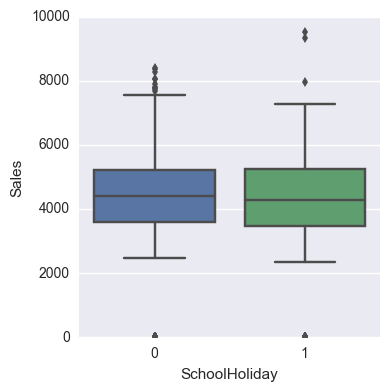

In [4]:
import seaborn as sb
%matplotlib inline

sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Check: See if there is a difference affecting sales on promotion days.

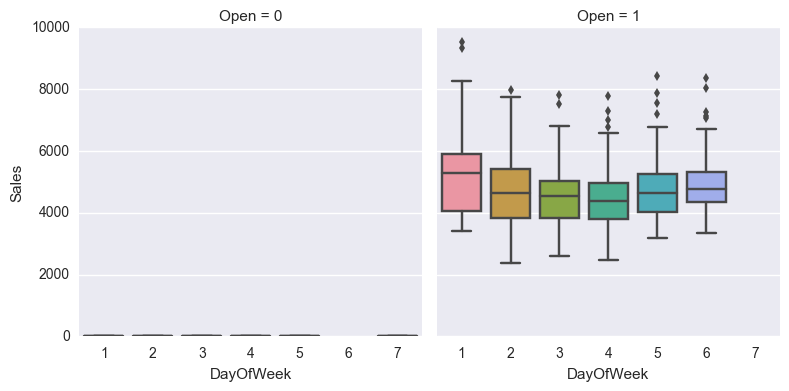

In [5]:
sb.factorplot(
    col='Open',
    x='DayOfWeek',
    y='Sales',
    data=store1_data,
    kind='box',
    
)

Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

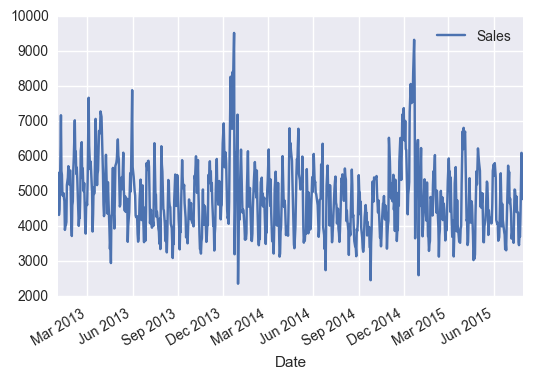

In [6]:
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()

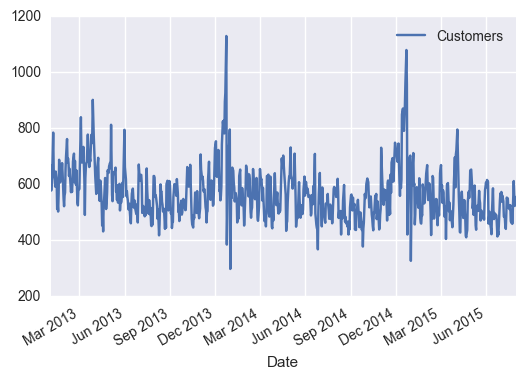

In [7]:
store1_open_data[['Customers']].plot()

In pandas we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

### Data REFINING Using Time Series Statistics

### Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column. In pandas, we do this we with the `autocorr` function.

`autocorr` takes one argument, the `lag` - which is how many prior data points should be used to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it, while setting `lag` to 10, computes the correlation between every point and the point 10 days earlier.

In [8]:
data['Sales'].resample('D').mean().autocorr(lag=1)

-0.025858276006383588

### Rolling Averages

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates.  We want to know what the mean and median sales were for each month and year.

In Pandas, this is performed using the `resample` command, which is very similar to the `groupby` command. It allows us to group over different time intervals.

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - What aggregation to perform: 'mean', 'median', 'sum', etc.

In [9]:
data[['Sales']].resample('M').apply(['median', 'mean']).head()

Sales             
            median         mean
Date                           
2013-01-31  5194.0  5211.555578
2013-02-28  5421.5  5494.371397
2013-03-31  5844.0  5820.349168
2013-04-30  5464.0  5483.749836
2013-05-31  5585.0  5364.127383

While identifying the monthly averages are useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare late December with the entire month, but perhaps a few days surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `df.rolling().mean()` or `df.rolling().median()` functions.

In [10]:
data[['Sales']].resample('D').mean().rolling(window=3, center=True).mean().head()

,Sales
Date,
2013-01-01,NaN
2013-01-02,4004.475720
2013-01-03,5960.120478
2013-01-04,5661.694170
2013-01-05,3807.010762


`rolling()` takes these important parameters:
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date
    - `freq` is on what level to roll-up the averages to (as used in `resample`). Either `D` for day, `M` for month or `A` for year, etc.

Instead of plotting the full timeseries, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

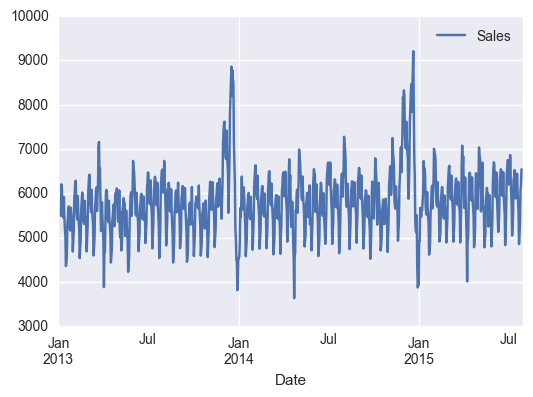

In [11]:
data[['Sales']].resample('D').mean().rolling(window=10, center=True).mean().plot()

### Pandas Window functions
Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions are operate on a set of N consecutive rows (a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one arugment, `periods`, which is how many prio rows to use for the difference.


In [12]:
data['Sales'].diff(periods=1).head()

Date
2015-07-31       NaN
2015-07-31     801.0
2015-07-31    2250.0
2015-07-31    5681.0
2015-07-31   -9173.0
Name: Sales, dtype: float64

### Pandas expanding functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, use all values up until that time.

In [13]:
# computes the average sales, from the first date _until_ the date specified.
data[['Sales']].resample('D').mean().expanding().mean().head()


,Sales
Date,
2013-01-01,87.284560
2013-01-02,3160.157527
2013-01-03,4004.475720
2013-01-04,4491.911499
2013-01-05,4661.079513


## Exercises

> Plot the distribution of sales by month and compare the effect of promotions

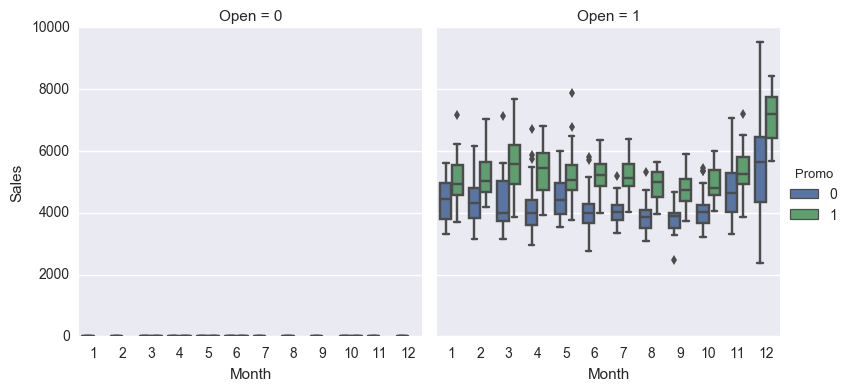

In [14]:
sb.factorplot(
    col='Open',
    hue='Promo',
    x='Month',
    y='Sales',
    data=store1_data, 
    kind='box'
)

> Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

In [15]:
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()

print('Correlation with last day: {}'.format(average_daily_sales['Sales'].autocorr(lag=1)))
print('Correlation with last month: {}'.format(average_daily_sales['Sales'].autocorr(lag=30)))
print('Correlation with last year: {}'.format(average_daily_sales['Sales'].autocorr(lag=365)))

Correlation with last day: -0.0258582760064
Correlation with last month: -0.129842458225
Correlation with last year: 0.0202385294483


> Plot the 15 day rolling mean of customers in the stores

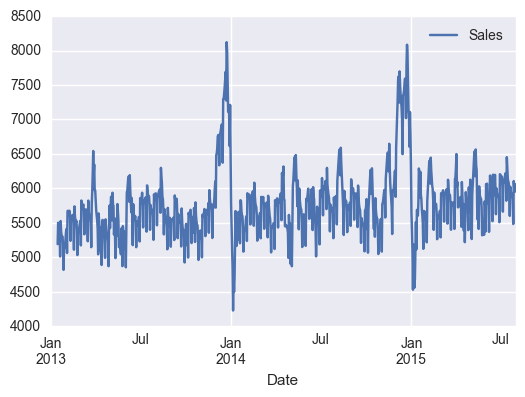

In [16]:
data[['Sales']].resample('D').mean().rolling(window=15).mean().plot()

> Identify the date with largest drop in sales from the same date in the previous month

In [17]:
average_daily_sales = data[['Sales', 'Open']].resample('D').mean()
average_daily_sales['DiffVsLastWeek'] = average_daily_sales[['Sales']].diff(periods=7)

average_daily_sales.sort_values(by='DiffVsLastWeek').head()

# Unsurprisingly, this day is Dec. 25 and Dec. 26 in 2014 and 2015. When the store is closed and there are many sales in the preceding week. How, about when the store is open?

average_daily_sales[average_daily_sales.Open == 1].sort_values(by='DiffVsLastWeek').head()

# The top values are Dec. 24 and then 2013-12-09 and 2013-10-14 where on average sales were 4k lower than the same day in the previous week.


,Sales,Open,DiffVsLastWeek
Date,,,
2013-12-24,4693.101345,1.0,-7014.515695
2014-12-24,4933.386096,1.0,-5209.272727
2013-12-09,6822.938117,1.0,-4811.537220
2013-10-14,5893.636771,1.0,-4027.798206
2015-04-20,5909.294170,1.0,-4023.443049


> Compute the total sales up until Dec. 2014

In [18]:
total_daily_sales = data[['Sales']].resample('D').sum()

total_daily_sales.expanding().sum()['2014-12'].head()


,Sales
Date,
2014-12-01,4.291837e+09
2014-12-02,4.300681e+09
2014-12-03,4.308939e+09
2014-12-04,4.317493e+09
2014-12-05,4.327295e+09


> When were the largest differences between 15-day moving/rolling averages?
> HINT: Using `rolling(...).mean()` and `diff`

In [19]:
data[['Sales']].resample('d').mean().rolling(window=15).mean().diff(1).sort_values(by='Sales').head()

# Unsurprisingly, they occur at the beginning of every year after the holiday season.

,Sales
Date,
2014-01-01,-773.446039
2015-01-01,-668.394774
2013-12-31,-663.000538
2014-01-05,-596.739073
2014-05-01,-585.158326
